# A Climatological Analysis of the Surface Drainage of the Amery Ice Shelf, East Antarctica

## Between summer air temperature amd summer cloud cover, which is a larger control on the size of surface meltwater lakes? 

#### Julian Spergel
#### Research Computing in Earth Sciences

In [1]:
from dask.diagnostics import ProgressBar
import numpy as np
import datetime
from datetime import date
import xarray as xr
import dask.array as da
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

Text(0.5,0.7,'Melt Lakes on the Amery Ice Shelf, East Antarctica, Jan 13, 2017')

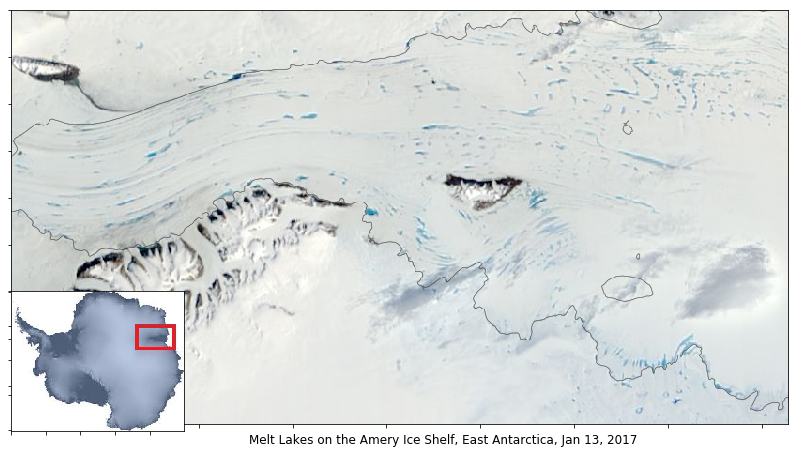

In [2]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_axes([0, 0, 0.9, 2])
ax2 = fig.add_axes([0, 0, 0.2, 1.6])
lakepicture = plt.imread('nasa-worldview_2017_01_13_1493062018.tif')
antarcticamap = plt.imread('simple_antarctica_wamery.jpg')
ax1.imshow(lakepicture)
ax1.set_xticklabels(labels=[],fontdict={'color':'w'})
ax1.set_yticklabels(labels=[],fontdict={'color':'w'})
ax2.set_xticklabels(labels=[],fontdict={'color':'w'})
ax2.set_yticklabels(labels=[],fontdict={'color':'w'})
ax2.imshow(antarcticamap)
fig.suptitle('Melt Lakes on the Amery Ice Shelf, East Antarctica, Jan 13, 2017', x=0.5,y=0.7)

## Amery Ice Shelf Meltwater Lakes

#### There are two datasets in which I tabulate observed meltwater lakes on the Amery 1973-2017. In the first, I record the area of a single, large lake at its peak size at the end of the austral summer. For the purposes of my research, I've nicknamed this lake "Big Lake". Using a single lake as a proxy, I can record melt conditions in years with very few cloud-free images. However, not every summer with melt fills the "Big Lake" basin.


In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

#### Figure 1. Big Lake surface area vs. year

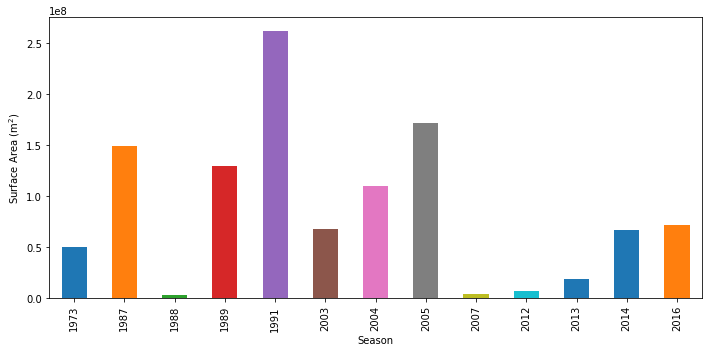

In [4]:
years= [1973,1987,1988,1989,1991,2003,2004,2005,2007,2012,2013,2014,2016]
biglakegeometry =pd.DataFrame(data={'years':[1973,1987,1988,1989,1991,2003,2004,2005,2007,2012,2013,2014,2016],
                              'BLarea': [50485500,148802000,3467700,129943000,262175616,67428000,110199000,171816000
                                         ,3839400,6787554,19089900,66546000,71992800]},index=years)
figure, ax = plt.subplots( figsize=(10,5))
biglakegeometry.BLarea.plot.bar(ax=ax)
ax.set_xlabel('Season')
ax.set_ylabel('Surface Area (m$^2$)')
figure.tight_layout()

In [5]:
BLarea = pd.DataFrame(data= biglakegeometry.BLarea, index=biglakegeometry.years)


### Amery Lake Mask Shapefiles

#### Second, I've collected the shapefiles of all the lakes on the Amery Ice Shelf detected using a simple band-threshold lake detection algorithm. This data is a more accurate assessment of the extent of meltwater lake formation in each year. However, because of the rarity of cloud-free imagery and the gaps in Landsat 7 imagery caused by a broken Scan-Line Corrector, many of the lake-shapes collected are incomplete. For this reason, surface area, lake size, etc cannot be accurately extrapolated from these shapefiles. 

In [2]:
import shapefile
import os

In [3]:
#Extracting list of shapefiles
shapefile_list = os.listdir()
shapefile_list_shp = []
for indx in np.arange(0, len(shapefile_list)):
    extension = shapefile_list[indx][-4:]
    if extension=='.shp':
        shapefile_list_shp.append(shapefile_list[indx][:-4])
        

In [4]:
year_list = [2005,2004,2017,2010,2006,2014,2003,2016,2015,1989,2011]
year_list = year_list - np.ones_like(year_list)
year_list

array([2004, 2003, 2016, 2009, 2005, 2013, 2002, 2015, 2014, 1988, 2010])

In [5]:
def PolygonArea(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

#Define a function to take the distance between 2 points on a sphere with lat/lon coordinates
def haversine(coord1: object, coord2: object):
    import math

    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 3)
    km = round(km, 3)
    return km


count = 0
area_sum = {}
areal_extent = {}
centroids_x = {}
centroids_y = {}
for shapefiles in shapefile_list_shp:
    a_shapefile = shapefile.Reader(shapefiles)
    a_shapefiles_shp = a_shapefile.shapes()
    polygon_area={}
    extent_ul = {}
    extent_lr = {}
    centroid_x = {}
    centroid_y = {}
    for indx in np.arange(0,len(a_shapefile)):
        polygon_area[indx] = PolygonArea(a_shapefiles_shp[indx].points)*111.69*111.66 #km/deg lat * km/deg lon near 80S
        extent_ul[indx] = [a_shapefiles_shp[indx].bbox[0],a_shapefiles_shp[indx].bbox[1]]
        extent_lr[indx] = [a_shapefiles_shp[indx].bbox[2],a_shapefiles_shp[indx].bbox[3]]
        centroid_x[indx] =(a_shapefiles_shp[indx].bbox[0]+a_shapefiles_shp[indx].bbox[2])/2
        centroid_y[indx] = (a_shapefiles_shp[indx].bbox[1]+a_shapefiles_shp[indx].bbox[3])/2

    year = year_list[count]
    area_sum[year] = sum(polygon_area.values())
    areal_extent[year] = haversine(min(extent_ul.values()),max(extent_lr.values())) #Distance between southwestmost and northeastmost lakes 
    centroids_x[year] = list(centroid_x.values())
    centroids_y[year] = list(centroid_y.values())
    count=count+1

In [6]:
AmeryLakes = pd.DataFrame(data= {'summed_area':list(area_sum.values()),
                                'areal_extent':list(areal_extent.values())},
                          index = year_list)
AmeryLakes = AmeryLakes.sort_index()

#### Figure 2. Left: Percent coverage by subaerial water vs. Year, Right:  Areal extent of lakes vs. Year

Text(0,0.5,'Areal Extent of Subaerial Water (km)')

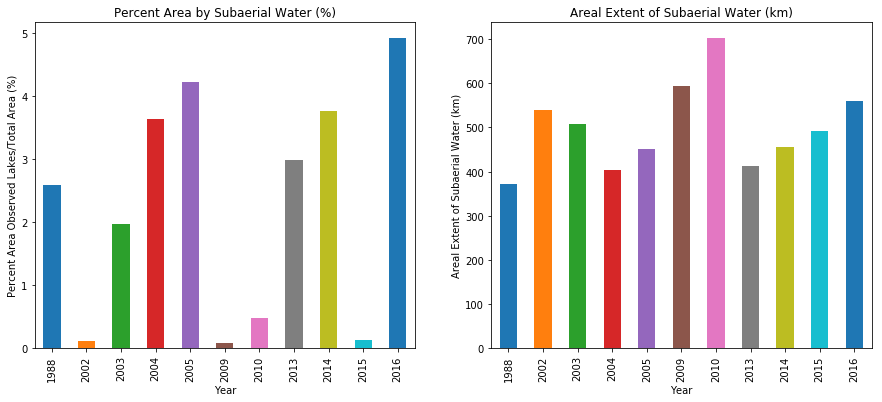

In [34]:
fig, ax = plt.subplots(figsize=(15,6), ncols=2)

total_area = 54516.221436 #measured total area of Amery Ice Shelf km^2

(100*AmeryLakes.summed_area/total_area).plot.bar(ax=ax[0], title='Percent Area Covered by Subaerial Water (%)')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Percent Area Observed Lakes/Total Area (%)')

AmeryLakes.areal_extent.plot.bar(ax=ax[1], title='Areal Extent of Lakes (km)')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Areal Extent of Subaerial Water (km)')

## PATMOSx Cloud Data
### Cloud fraction data from PATMOSx, a cloud properties product that combines MODIS, AVHRR, and GOES

In [4]:
ds = xr.open_dataset('http://www.ncei.noaa.gov/thredds/dodsC/avhrr-patmos-x-cloudprops-noaa-asc-fc/PATMOS-X_Cloud_Properties:_Aggregation,_NOAA_ascending_best.ncd')

In [5]:
cloud_fract = ds.cloud_fraction.sel(latitude=slice(-75,-65),longitude=slice(50,85),time=slice('1998-01-01','2017-06-30'))
coastlines = ds.land_class.sel(time='1998-01-01',latitude=slice(-75,-65),longitude=slice(50,85)).where('land_class'==2)

#### The server times out if the requested time-slice is too long, so each summer is manually subsetted and then concatenated

In [6]:
summer_cloudiness_1999 = cloud_fract.sel(time=slice(datetime.date(1998,12,1),datetime.date(1999,3,1))).mean(dim='time')
summer_cloudiness_2000 = cloud_fract.sel(time=slice(datetime.date(1999,12,1),datetime.date(2000,3,1))).mean(dim='time')
summer_cloudiness_2001 = cloud_fract.sel(time=slice(datetime.date(2000,12,1),datetime.date(2001,3,1))).mean(dim='time')
summer_cloudiness_2002 = cloud_fract.sel(time=slice(datetime.date(2001,12,1),datetime.date(2002,3,1))).mean(dim='time')
summer_cloudiness_2003 = cloud_fract.sel(time=slice(datetime.date(2002,12,1),datetime.date(2003,3,1))).mean(dim='time')
summer_cloudiness_2004 = cloud_fract.sel(time=slice(datetime.date(2003,12,1),datetime.date(2004,3,1))).mean(dim='time')
summer_cloudiness_2005 = cloud_fract.sel(time=slice(datetime.date(2004,12,1),datetime.date(2005,3,1))).mean(dim='time')
summer_cloudiness_2006 = cloud_fract.sel(time=slice(datetime.date(2005,12,1),datetime.date(2006,3,1))).mean(dim='time')
summer_cloudiness_2007 = cloud_fract.sel(time=slice(datetime.date(2006,12,1),datetime.date(2007,3,1))).mean(dim='time')
summer_cloudiness_2008 = cloud_fract.sel(time=slice(datetime.date(2007,12,1),datetime.date(2008,3,1))).mean(dim='time')
summer_cloudiness_2009 = cloud_fract.sel(time=slice(datetime.date(2008,12,1),datetime.date(2009,3,1))).mean(dim='time')
summer_cloudiness_2010 = cloud_fract.sel(time=slice(datetime.date(2009,12,1),datetime.date(2010,3,1))).mean(dim='time')
summer_cloudiness_2011 = cloud_fract.sel(time=slice(datetime.date(2010,12,1),datetime.date(2011,3,1))).mean(dim='time')
summer_cloudiness_2012 = cloud_fract.sel(time=slice(datetime.date(2011,12,1),datetime.date(2012,3,1))).mean(dim='time')
summer_cloudiness_2013 = cloud_fract.sel(time=slice(datetime.date(2012,12,1),datetime.date(2013,3,1))).mean(dim='time')
summer_cloudiness_2014 = cloud_fract.sel(time=slice(datetime.date(2013,12,1),datetime.date(2014,3,1))).mean(dim='time')
summer_cloudiness_2015 = cloud_fract.sel(time=slice(datetime.date(2014,12,1),datetime.date(2015,3,1))).mean(dim='time')
summer_cloudiness_2016 = cloud_fract.sel(time=slice(datetime.date(2015,12,1),datetime.date(2016,3,1))).mean(dim='time')
summer_cloudiness_2017 = cloud_fract.sel(time=slice(datetime.date(2016,12,1),datetime.date(2017,3,1))).mean(dim='time')


In [7]:
summer_cloudiness = xr.concat([summer_cloudiness_1999,summer_cloudiness_2000,summer_cloudiness_2001,summer_cloudiness_2003,
                              summer_cloudiness_2004,summer_cloudiness_2005,summer_cloudiness_2006,summer_cloudiness_2007,
                             summer_cloudiness_2008,summer_cloudiness_2009,summer_cloudiness_2010,summer_cloudiness_2011,
                             summer_cloudiness_2012,summer_cloudiness_2013,summer_cloudiness_2014,summer_cloudiness_2015,
                             summer_cloudiness_2016,summer_cloudiness_2017],dim='time')

In [8]:
summer_cloudiness.to_netcdf('summer_cloudiness2','w')

In [7]:
summer_cloudiness = xr.open_dataset('summer_cloudiness2')
summer_cloudiness

<xarray.Dataset>
Dimensions:         (latitude: 100, longitude: 350, time: 18)
Coordinates:
  * latitude        (latitude) float32 -74.94827 -74.84939 -74.747765 ...
  * longitude       (longitude) float32 50.049744 50.148624 50.247505 ...
Dimensions without coordinates: time
Data variables:
    cloud_fraction  (time, latitude, longitude) float32 ...

#### Figure 3. The mean summer cloud fraction for each pixel is plotted in the top panel, then an areal average is taken for each year and de-meaned to show the cloudiness anomaly (lower panel)

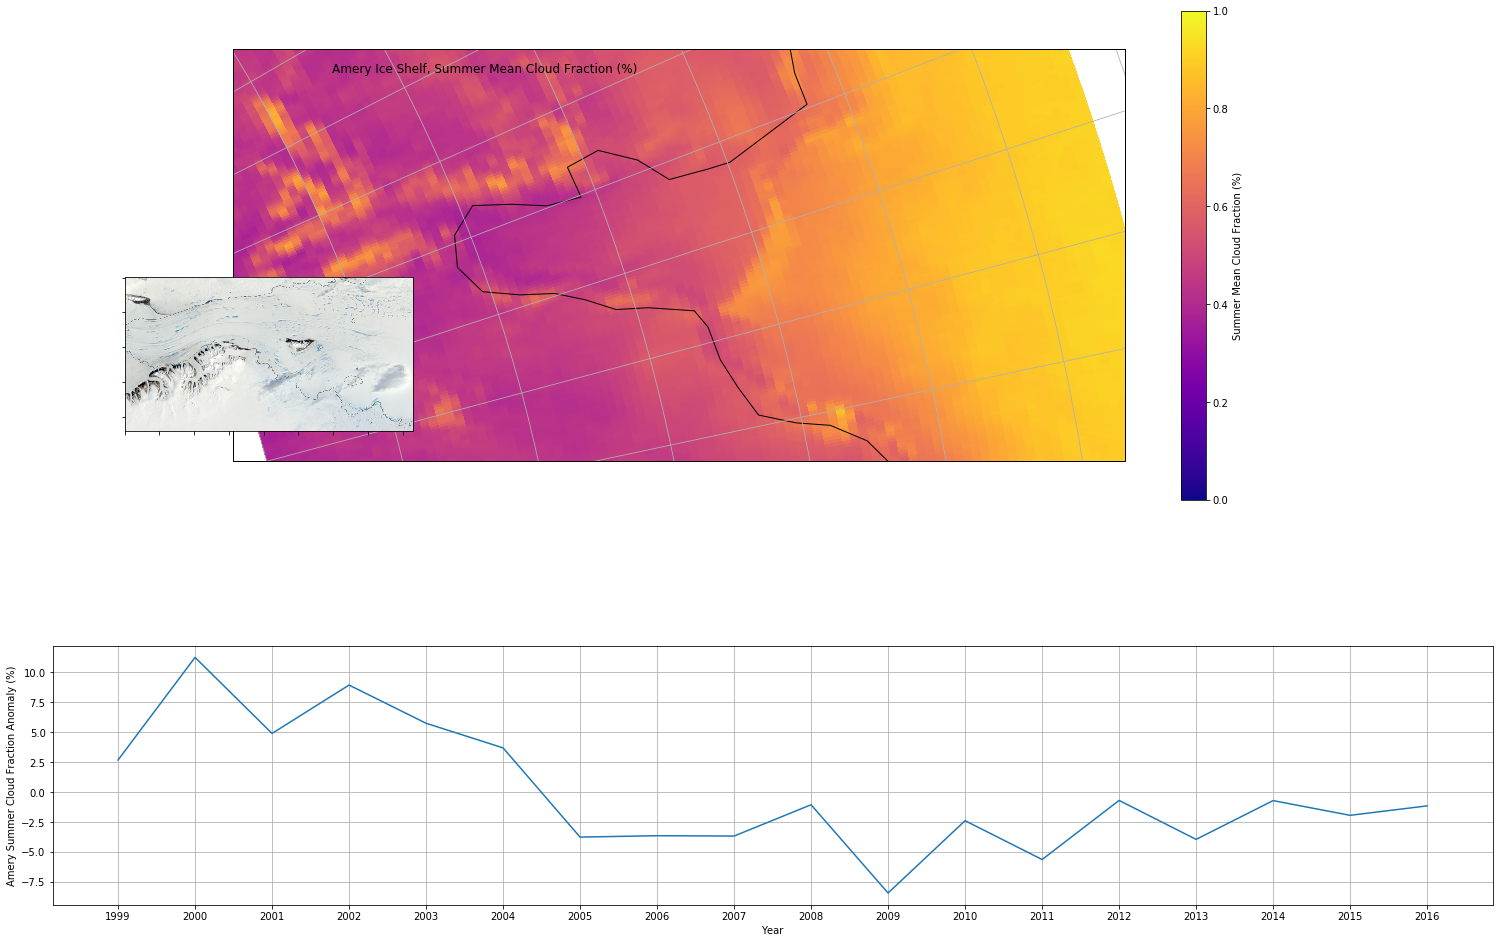

In [68]:
%matplotlib inline
years = np.arange(1999,2017)
figure = plt.figure(figsize=(20, 9))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([70, 75, -75, -65], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
summerplot = summer_cloudiness.cloud_fraction.mean(dim='time').plot(ax=ax,vmin=0,vmax=1,transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={'label':'Summer Mean Cloud Fraction (%)'},
                                                                   cmap='plasma')
ax2 = figure.add_axes([0.05, 0, 0.2, 0.7])
ax2.imshow(lakepicture)
ax2.set_xticklabels(labels=[],fontdict={'color':'w'})
ax2.set_yticklabels(labels=[],fontdict={'color':'w'})
figure.suptitle('Amery Ice Shelf, Summer Mean Cloud Fraction (%)',y=0.8, x=.3);


years = np.arange(1999,2017)
ax3 = figure.add_axes([0,-.5,1,0.4])
anomalyplot = 100*(summer_cloudiness.cloud_fraction.mean(dim=['latitude','longitude'])
                - summer_cloudiness.cloud_fraction.mean(dim=['latitude','longitude']).mean('time'))
#ax.set_xticklabels(summer_cloudiness.time.values+1999)
anomalycloudiness = pd.Series(anomalyplot.data.tolist(), index=years)
anomalycloudiness.plot(grid=True,xticks=years, ax=ax3)
ax3.set_ylabel('Amery Summer Cloud Fraction Anomaly (%)')
ax3.set_xlabel('Year');


#### Figure 4. Top panel: A spatial zoom of the mean summer cloud fraction plot, with the locations of "Big Lake" (a large meltwater lake) and the Automatic Weather Station (AWS) used later in the study. Lower panel: The summer cloud fraction mean for the pixels over Big Lake.

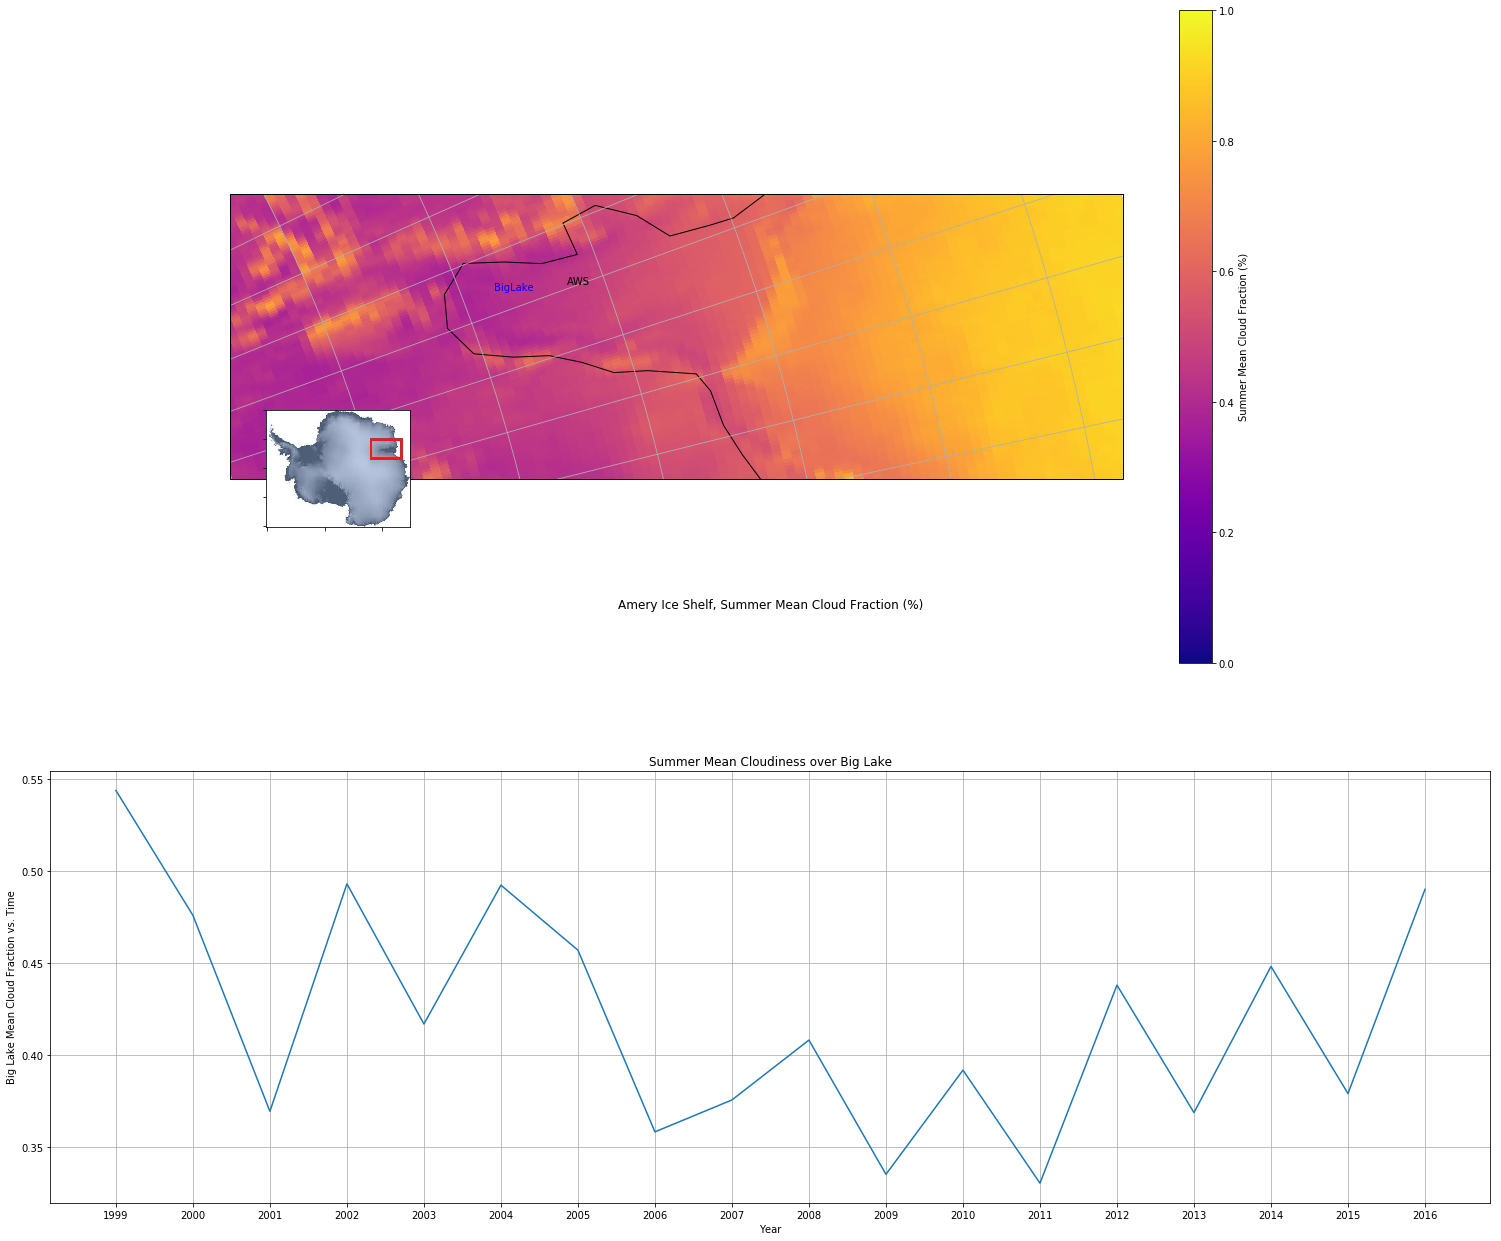

In [11]:
figure = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([72.5, 72.7, -75, -65], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
summerplot = summer_cloudiness.cloud_fraction.mean(dim='time').plot(ax=ax,vmin=0,vmax=1,transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={'label':'Summer Mean Cloud Fraction (%)'},
                                                                   cmap='plasma')
ax.text(x= 69.19, y=-71.64953,s='BigLake', transform=ccrs.PlateCarree(),color='b')
ax.text(69.8725,-70.8919,'AWS', transform=ccrs.PlateCarree())
ax2 = figure.add_axes([0.15, 0, 0.1, 0.7])
ax2.imshow(antarcticamap)
ax2.set_xticklabels(labels=[],fontdict={'color':'w'})
ax2.set_yticklabels(labels=[],fontdict={'color':'w'})
figure.suptitle('Amery Ice Shelf, Summer Mean Cloud Fraction (%)',y=0.2);

ax3 = figure.add_axes([0,-.5,1,0.5])
ax3.set_ylabel('Big Lake Mean Cloud Fraction vs. Time')
ax3.set_xlabel('Year');

years = np.arange(1999,2017)
BigLake_list = summer_cloudiness.sel(latitude=slice(-71.64953,-71.5),longitude=slice(69.19,69.25)).mean(dim='latitude')
BigLake_summercloudiness = pd.DataFrame({'cloudiness':BigLake_list.cloud_fraction.values.squeeze()}, index=years)
BigLake_summercloudiness.plot(grid=True, xticks=years, ax=ax3,
                              legend=False,title = 'Summer Mean Cloudiness over Big Lake')

## AWS Temperature Data from Amery G3 AWS

#### The Australian Antarctic Division installed several automatic weather stations in the 1990s. The one on the Amery Ice Shelf, Amery G3, collected climate data from 1999-present. However, the only thermometer to continously function through its operation period was Air Temperature, 4m above the surface (AiT4), and this instrument stopped recording temperatures regularly in ~2014. Wind and surface air temperature (WVM and AiT1) stopped functioning ~2005.

In [12]:
! wget http://aws.acecrc.org.au/data/AmeryG3_antarctic_aws_1999_2017.nc

--2018-12-04 20:24:59--  http://aws.acecrc.org.au/data/AmeryG3_antarctic_aws_1999_2017.nc
Resolving aws.acecrc.org.au (aws.acecrc.org.au)... 144.6.226.118
Connecting to aws.acecrc.org.au (aws.acecrc.org.au)|144.6.226.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9260468 (8.8M) [application/x-netcdf]
Saving to: ‘AmeryG3_antarctic_aws_1999_2017.nc.1’

AmeryG3_antarctic_a 100%[===================>]   8.83M  4.29MB/s    in 2.1s    

2018-12-04 20:25:02 (4.29 MB/s) - ‘AmeryG3_antarctic_aws_1999_2017.nc.1’ saved [9260468/9260468]



In [13]:
import xarray as xr
import pandas as pd
import numpy as np
AmeryAWS = xr.open_dataset('AmeryG3_antarctic_aws_1999_2017.nc')
AmeryAWS.Time
AmeryAWS = AmeryAWS.swap_dims({'time':'Time'})


In [14]:
AiT4 = AmeryAWS.AiT4
AiT1 = AmeryAWS.AiT1
WVM = AmeryAWS.WVM


#fig, ax = plt.subplots(nrows=2)
#AiT4.sel(Time=slice(datetime.datetime(2017,1,1), datetime.datetime(2017,6,30))).plot(ax=ax[0])
#WVM.plot(ax=ax[1])
#fig.tight_layout()

In [15]:
temperature_compare = xr.merge([AiT1,AiT4, WVM],'no_conflicts')
summers = temperature_compare.where(temperature_compare.Time.dt.season=='DJF')

#Because the austral summer straddles the year division, the temperature data needs to be re-indexed so that 
#the austral summer is contained within the same year.

import datetime
summer_reindexed = summers.shift(Time=-90)

In [30]:
summer_AiT4_anom = (summer_reindexed.AiT4.resample('1Y', dim='Time') 
                    - summer_reindexed.AiT4.resample('1Y', dim='Time').mean(dim='Time'))
summer_AiT4_anom = pd.DataFrame(data={'summer_anom':summer_AiT4_anom.values}, index = summer_AiT4_anom.Time.dt.year)
summer_AiT4_anom.rename_axis('years')

summer_AiT4_PDD = summer_reindexed.AiT4.where(summer_reindexed.AiT4>0).groupby(summer_reindexed.Time.dt.year).count()/24
summer_PDD = pd.DataFrame(data = {'Positive_Degree_Days': summer_AiT4_PDD}, index = summer_AiT4_PDD.year)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(Time="1Y").mean('Time') 
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(Time="1Y").mean('Time') 
  


#### Figure 5. Top panel: mean summer air temperature anomaly, 1999-2017. Lower panel: Count of days with positive air temperatures vs. year ((hours with T>0)/(24 hours)))

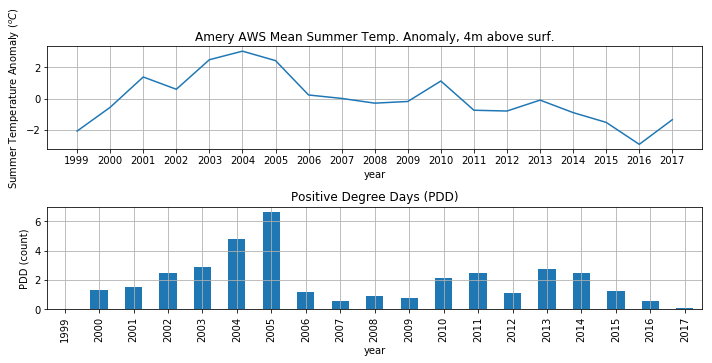

In [31]:
figure, ax = plt.subplots(nrows=2, figsize=(10,5))
summer_AiT4_anom.plot(ax=ax[0], grid=True, xticks = summer_AiT4_anom.index, title='Amery AWS Mean Summer Temp. Anomaly, 4m above surf.',
                     legend=False)

ax[0].set_ylabel('Summer Temperature Anomaly ($^oC$)');
summer_PDD.plot.bar(ax=ax[1], grid=True, xticks = summer_PDD.index, title = 'Positive Degree Days (PDD)',
               legend=False)
ax[1].set_ylabel('PDD (count)');
figure.tight_layout()

#### Figure 6. Comparison between temperature measurements, cloud fraction measurements, and Big Lake surface areas 

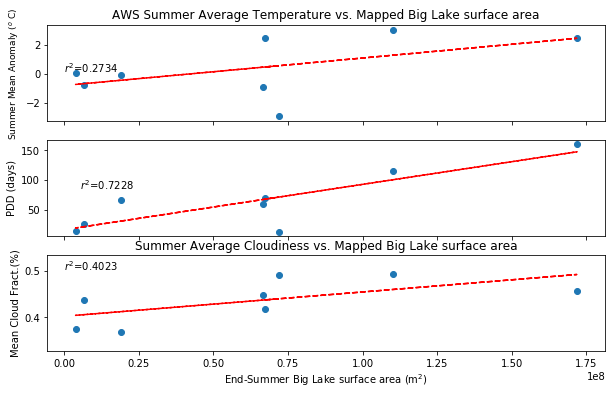

In [27]:
lakesize_temperature= pd.merge(BLarea,summer_AiT4_anom,left_on=BLarea.index,right_on=summer_AiT4_anom.index)
lakesize_PDD = pd.merge(BLarea,summer_PDD,left_on=BLarea.index,right_on=summer_PDD.index)

fig, ax = plt.subplots(figsize=(10,6),nrows=3,sharex=True)

ax[0].scatter(x=lakesize_temperature.BLarea, y=lakesize_temperature.summer_anom)
ax[0].set_ylabel('Summer Mean Anomaly ($^o$ C)', fontsize=9)
ax[0].set_title('AWS Summer Average Temperature vs. Mapped Big Lake surface area');
z_1 = np.polyfit(lakesize_temperature.BLarea, lakesize_temperature.summer_anom, 1)
p_1 = np.poly1d(z_1)
ax[0].plot(lakesize_temperature.BLarea,p_1(lakesize_temperature.BLarea),"r--")
corrcoeff = (np.corrcoef(lakesize_temperature.BLarea, lakesize_temperature.summer_anom)[0,1])**2
ax[0].text(0.5,0.1,'$r^2$=' + str(np.round(corrcoeff,4)))

ax[1].scatter(x=lakesize_PDD.BLarea, y=lakesize_PDD.Positive_Degree_Days)
#ax[1].set_xlabel('End-Summer Big Lake surface area (m$^2)')
ax[1].set_ylabel('PDD (days)')
corrcoeff = (np.corrcoef(lakesize_PDD.BLarea, lakesize_PDD.Positive_Degree_Days)[0,1])**2
fig.text(0.17,0.5,'$r^2$=' + str(np.round(corrcoeff,4)))
z_2 = np.polyfit(lakesize_temperature.BLarea, lakesize_PDD.Positive_Degree_Days, 1)
p_2 = np.poly1d(z_2)
ax[1].plot(lakesize_temperature.BLarea,p_2(lakesize_temperature.BLarea),"r--")


BigLake_summercloudiness_xr = xr.Dataset(BigLake_summercloudiness)
lakesize_cloudiness= pd.merge(BLarea,BigLake_summercloudiness,left_on=BLarea.index,right_on=BigLake_summercloudiness.index)
ax[2].scatter(x=lakesize_cloudiness.BLarea, y=lakesize_cloudiness.cloudiness)
corrcoeff = (np.corrcoef(lakesize_cloudiness.BLarea, lakesize_cloudiness.cloudiness)[0,1])**2
ax[2].text(0.5,0.5,'$r^2$=' + str(np.round(corrcoeff,4)))
z = np.polyfit(lakesize_cloudiness.BLarea, lakesize_cloudiness.cloudiness, 1)
p_3 = np.poly1d(z)
ax[2].plot(lakesize_cloudiness.BLarea,p_3(lakesize_cloudiness.BLarea),"r--")
ax[2].set_xlabel('End-Summer Big Lake surface area (m$^2$)')
ax[2].set_ylabel('Mean Cloud Fract.(%)')
ax[2].set_title('Summer Average Cloudiness vs. Mapped Big Lake surface area');

figure.tight_layout()

#### Figure 7. Amery Lake Extent vs. temperature, Positive Degree Days, and cloud fraction

In [28]:
lakeshapes_temperature= pd.merge(AmeryLakes,summer_AiT4_anom,left_on=AmeryLakes.index,right_on=summer_AiT4_anom.index)
lakeshapes_PDD = pd.merge(AmeryLakes,summer_PDD,left_on=AmeryLakes.index,right_on=summer_PDD.index)
lakeshapes_cloudiness = pd.merge(AmeryLakes,anomalycloudiness.to_frame(name='cloud_anom'),left_on=AmeryLakes.index,
                                 right_on=anomalycloudiness.index)

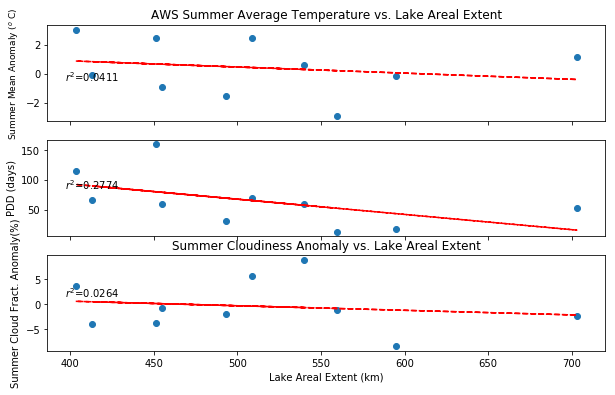

In [48]:
fig, ax = plt.subplots(figsize=(10,6),nrows=3,sharex=True)

ax[0].scatter(x=lakeshapes_temperature.areal_extent, y=lakeshapes_temperature.summer_anom)
ax[0].set_ylabel('Summer Mean Anomaly ($^o$ C)', fontsize=9)
ax[0].set_title('AWS Summer Average Temperature vs. Lake Areal Extent');
z_1 = np.polyfit(lakeshapes_temperature.areal_extent, lakeshapes_temperature.summer_anom, 1)
p_1 = np.poly1d(z_1)
ax[0].plot(lakeshapes_temperature.areal_extent,p_1(lakeshapes_temperature.areal_extent),"r--")
corrcoeff = (np.corrcoef(lakeshapes_temperature.areal_extent, lakeshapes_temperature.summer_anom)[0,1])**2
fig.text(.15,.75,'$r^2$=' + str(np.round(corrcoeff,4)))

ax[1].scatter(x=lakeshapes_PDD.areal_extent, y=lakeshapes_PDD.Positive_Degree_Days)
#ax[1].set_xlabel('End-Summer Big Lake surface area (m$^2)')
ax[1].set_ylabel('PDD (days)')
corrcoeff = (np.corrcoef(lakeshapes_PDD.areal_extent, lakeshapes_PDD.Positive_Degree_Days)[0,1])**2
fig.text(0.15,0.5,'$r^2$=' + str(np.round(corrcoeff,4)))
z_2 = np.polyfit(lakeshapes_PDD.areal_extent, lakeshapes_PDD.Positive_Degree_Days, 1)
p_2 = np.poly1d(z_2)
ax[1].plot(lakeshapes_PDD.areal_extent,p_2(lakeshapes_PDD.areal_extent),"r--")

ax[2].scatter(x=lakeshapes_cloudiness.areal_extent, y=lakeshapes_cloudiness.cloud_anom)
corrcoeff = (np.corrcoef(lakeshapes_cloudiness.areal_extent, lakeshapes_cloudiness.cloud_anom)[0,1])**2
fig.text(.15,.27,'$r^2$=' + str(np.round(corrcoeff,4)))
z = np.polyfit(lakeshapes_cloudiness.areal_extent, lakeshapes_cloudiness.cloud_anom, 1)
p_3 = np.poly1d(z)
ax[2].plot(lakeshapes_cloudiness.areal_extent,p_3(lakeshapes_cloudiness.areal_extent),"r--")
ax[2].set_xlabel('Lake Areal Extent (km)')
ax[2].set_ylabel('Summer Cloud Fract. Anomaly(%)')
ax[2].set_title('Summer Cloudiness Anomaly vs. Lake Areal Extent');

figure.tight_layout()

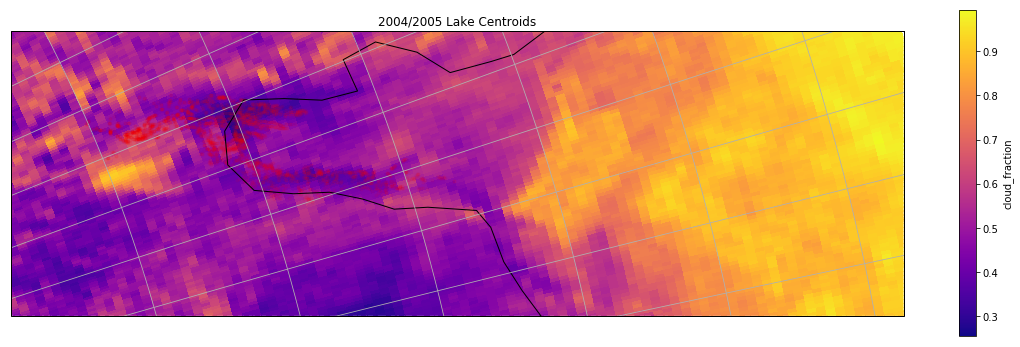

In [19]:
figure = plt.figure(figsize=(20, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([72.5, 72.7, -75, -65], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
cloudyplot = summer_cloudiness.sel(time=5).cloud_fraction.plot(ax=ax, transform = ccrs.PlateCarree(), cmap='plasma', )
ax.scatter(centroids_x[2004],centroids_y[2004],transform=ccrs.PlateCarree(),marker='.', color='r', alpha=0.05)
plt.title('2004/2005 Lake Centroids');


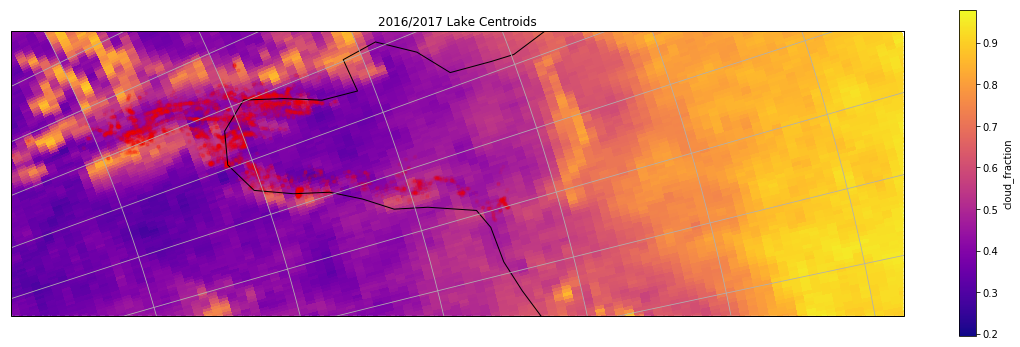

In [20]:
figure = plt.figure(figsize=(20, 6))
ax2 = plt.axes(projection=ccrs.SouthPolarStereo())
ax2.set_extent([72.5, 72.7, -75, -65], ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines()
summer_cloudiness.sel(time=17).cloud_fraction.plot(ax=ax2, transform = ccrs.PlateCarree(), cmap='plasma')
ax2.scatter(centroids_x[2016],centroids_y[2016],transform=ccrs.PlateCarree(),marker='.', color='r',alpha=0.05)
plt.title('2016/2017 Lake Centroids');


## Conclusions

#### 1. Cloudiness may affect the location of lake formation, but the poor correlation between cloud fraction and lake size indicates that cloud cover is not a strong control of lake size.
#### 2. The number of positive degree days has a strong correlation with the size of Big Lake, but not with the areal extent of where lakes form.
#### 3. The aerial extent of lake appearance seems to increase with consecutive years of lake formation, suggesting there is a cumulative effect in meltwater lake formation. Possible mechanisms are albedo effects, snow porosity, and latent thermal effects.